In [1]:
import os, sys
sys.path.append("../../common/")
from python_tools import *
import scipy.optimize
import numba_scipy
from numba import jit, float32

python tools loaded.


In [2]:
%matplotlib notebook

In [3]:
cov_file = uproot.open("/Users/wketchum/Data/MicroBooNE/LEEFits/dllee_fd2/total_sys_pred.SBNcovar.root")
mc_file = uproot.open("/Users/wketchum/Data/MicroBooNE/LEEFits/dllee_fd2/sens_pred.SBNspec.root")
data_file = uproot.open("/Users/wketchum/Data/MicroBooNE/LEEFits/dllee_fd2/fakedata.SBNspec.root")

In [4]:
print(cov_file.keys())
print(mc_file.keys())
print(data_file.keys())

[b'full_covariance;1', b'frac_covariance;1', b'full_correlation;1', b'collapsed_covariance;1', b'collapsed_frac_covariance;1', b'collapsed_correlation;1']
[b'nu_uBooNE_1e1p_bnb;1', b'nu_uBooNE_1e1p_lee;1', b'nu_uBooNE_1mu1p_bnb;1']
[b'nu_uBooNE_1e1p_bnb;1', b'nu_uBooNE_1e1p_lee;1', b'nu_uBooNE_1mu1p_bnb;1']


In [5]:
NUE_EXP = mc_file["nu_uBooNE_1e1p_bnb"].numpy()[0]
NUMU_EXP = mc_file["nu_uBooNE_1mu1p_bnb"].numpy()[0]
SIG_EXP = mc_file["nu_uBooNE_1e1p_lee"].numpy()[0]

DATA_EXP = np.append(np.copy(NUE_EXP),NUMU_EXP)
SIG_EXP = np.append(SIG_EXP,np.full_like(NUMU_EXP,0))

In [6]:
NUE_OBS = data_file["nu_uBooNE_1e1p_bnb"].numpy()[0]
NUMU_OBS = data_file["nu_uBooNE_1mu1p_bnb"].numpy()[0]
DATA_OBS = np.append(np.copy(NUE_OBS),NUMU_OBS)

In [7]:
m = cov_file["collapsed_covariance"]
M_COV_SYS = np.copy(m._fElements.reshape(m._fNrows, m._fNcols))
M_COV_SYS = np.float32(M_COV_SYS)
M_COV_NUE_SYS = M_COV_SYS[:10,:10]
M_COV_NUMU_SYS = M_COV_SYS[10:,10:]
M_COV_EM_SYS = M_COV_SYS[:10,10:]
M_COV_ME_SYS = M_COV_SYS[10:,:10]

M_COV_SYS_INV = np.linalg.inv(M_COV_SYS)
M_COV_NUE_SYS_INV = np.linalg.inv(M_COV_NUE_SYS)
M_COV_NUMU_SYS_INV = np.linalg.inv(M_COV_NUMU_SYS)

M_COV = np.copy(M_COV_SYS) + np.diagflat(DATA_EXP)
M_COV_SIG = np.copy(M_COV_SYS) + np.diagflat(DATA_EXP+SIG_EXP)

M_COV_NUE = M_COV[:10,:10]
M_COV_NUMU = M_COV[10:,10:]
M_COV_EM = M_COV[:10,10:]
M_COV_ME = M_COV[10:,:10]

M_COV_INV = np.linalg.inv(M_COV)
M_COV_SIG_INV = np.linalg.inv(M_COV_SIG)
M_COV_NUE_INV = np.linalg.inv(M_COV_NUE)
M_COV_NUMU_INV = np.linalg.inv(M_COV_NUMU)

IDENTITY_FULL = np.identity(len(SIG_EXP))

In [8]:
#useful for speedups
M_INV_S = np.matmul(M_COV_INV,np.diagflat(SIG_EXP))
M_INV_S_M_INV = np.matmul(M_INV_S,M_COV_INV)

In [9]:
def M_COV_INV_FAST_FULL(mu=1.0):
    #just in case you ask for zero...
    if np.isclose(mu,0.0): 
        return M_COV_INV
    else:
        return M_COV_INV - mu*np.matmul(np.linalg.inv(IDENTITY_FULL+mu*M_INV_S),
                                        M_INV_S_M_INV)

In [10]:
def CHI2(diff,m_cov_inv):
    return np.matmul(np.transpose(diff),np.matmul(m_cov_inv,diff))

def COND_EXP(diff1,exp2,m_cov_11_inv,m_cov_21):
    return exp2 + np.matmul(m_cov_21,np.matmul(m_cov_11_inv,diff1))

def COND_COV(m_cov_22,m_cov_11_inv,m_cov_12,m_cov_21):
    return m_cov_22 - np.matmul(m_cov_21,np.matmul(m_cov_11_inv,m_cov_12))

def CHI2_SIG_FULL(x,data):
    return CHI2(data - (x*SIG_EXP+DATA_EXP),M_COV_INV_FAST_FULL(x))

In [11]:
NUE_EXP_COND = COND_EXP(NUMU_OBS-NUMU_EXP,NUE_EXP,M_COV_NUMU_INV,M_COV_EM)
#M_COV_COND_SYS = COND_COV(M_COV_NUE_SYS,M_COV_NUMU_SYS_INV,M_COV_ME_SYS,M_COV_EM_SYS)
#M_COV_COND = np.copy(M_COV_COND_SYS) + np.diagflat(NUE_EXP_COND)
#M_COV_COND_INV = np.linalg.inv(M_COV_COND)

M_COV_COND_SYS = COND_COV(M_COV_NUE_SYS,np.linalg.inv(M_COV_NUMU_SYS+np.diagflat(NUMU_EXP)),M_COV_ME_SYS,M_COV_EM_SYS)
M_COV_COND = np.copy(M_COV_COND_SYS) + np.diagflat(NUE_EXP_COND)
M_COV_COND_INV = np.linalg.inv(M_COV_COND)

SIG_EXP_COND = SIG_EXP[:10]# * (NUE_EXP_COND)/NUE_EXP
M_COV_SIG_COND = np.copy(M_COV_COND_SYS) + np.diagflat(SIG_EXP_COND)+np.diagflat(NUE_EXP_COND)
M_COV_SIG_COND_INV = np.linalg.inv(M_COV_SIG_COND)


In [12]:
IDENTITY_COND = np.identity(len(SIG_EXP_COND))
M_INV_S_COND = np.matmul(M_COV_COND_INV,np.diagflat(SIG_EXP_COND))
M_INV_S_M_INV_COND = np.matmul(M_INV_S_COND,M_COV_COND_INV)

In [13]:
def M_COV_INV_FAST_COND(mu=1.0):
    #just in case you ask for zero...
    if np.isclose(mu,0.0): 
        return M_COV_COND_INV
    else:
        return M_COV_COND_INV - mu*np.matmul(np.linalg.inv(IDENTITY_COND+mu*M_INV_S_COND),
                                        M_INV_S_M_INV_COND)
    
def CHI2_SIG_COND(x,data):
    return CHI2(data - (x*SIG_EXP_COND+NUE_EXP_COND),M_COV_INV_FAST_COND(x))



<IPython.core.display.Javascript object>


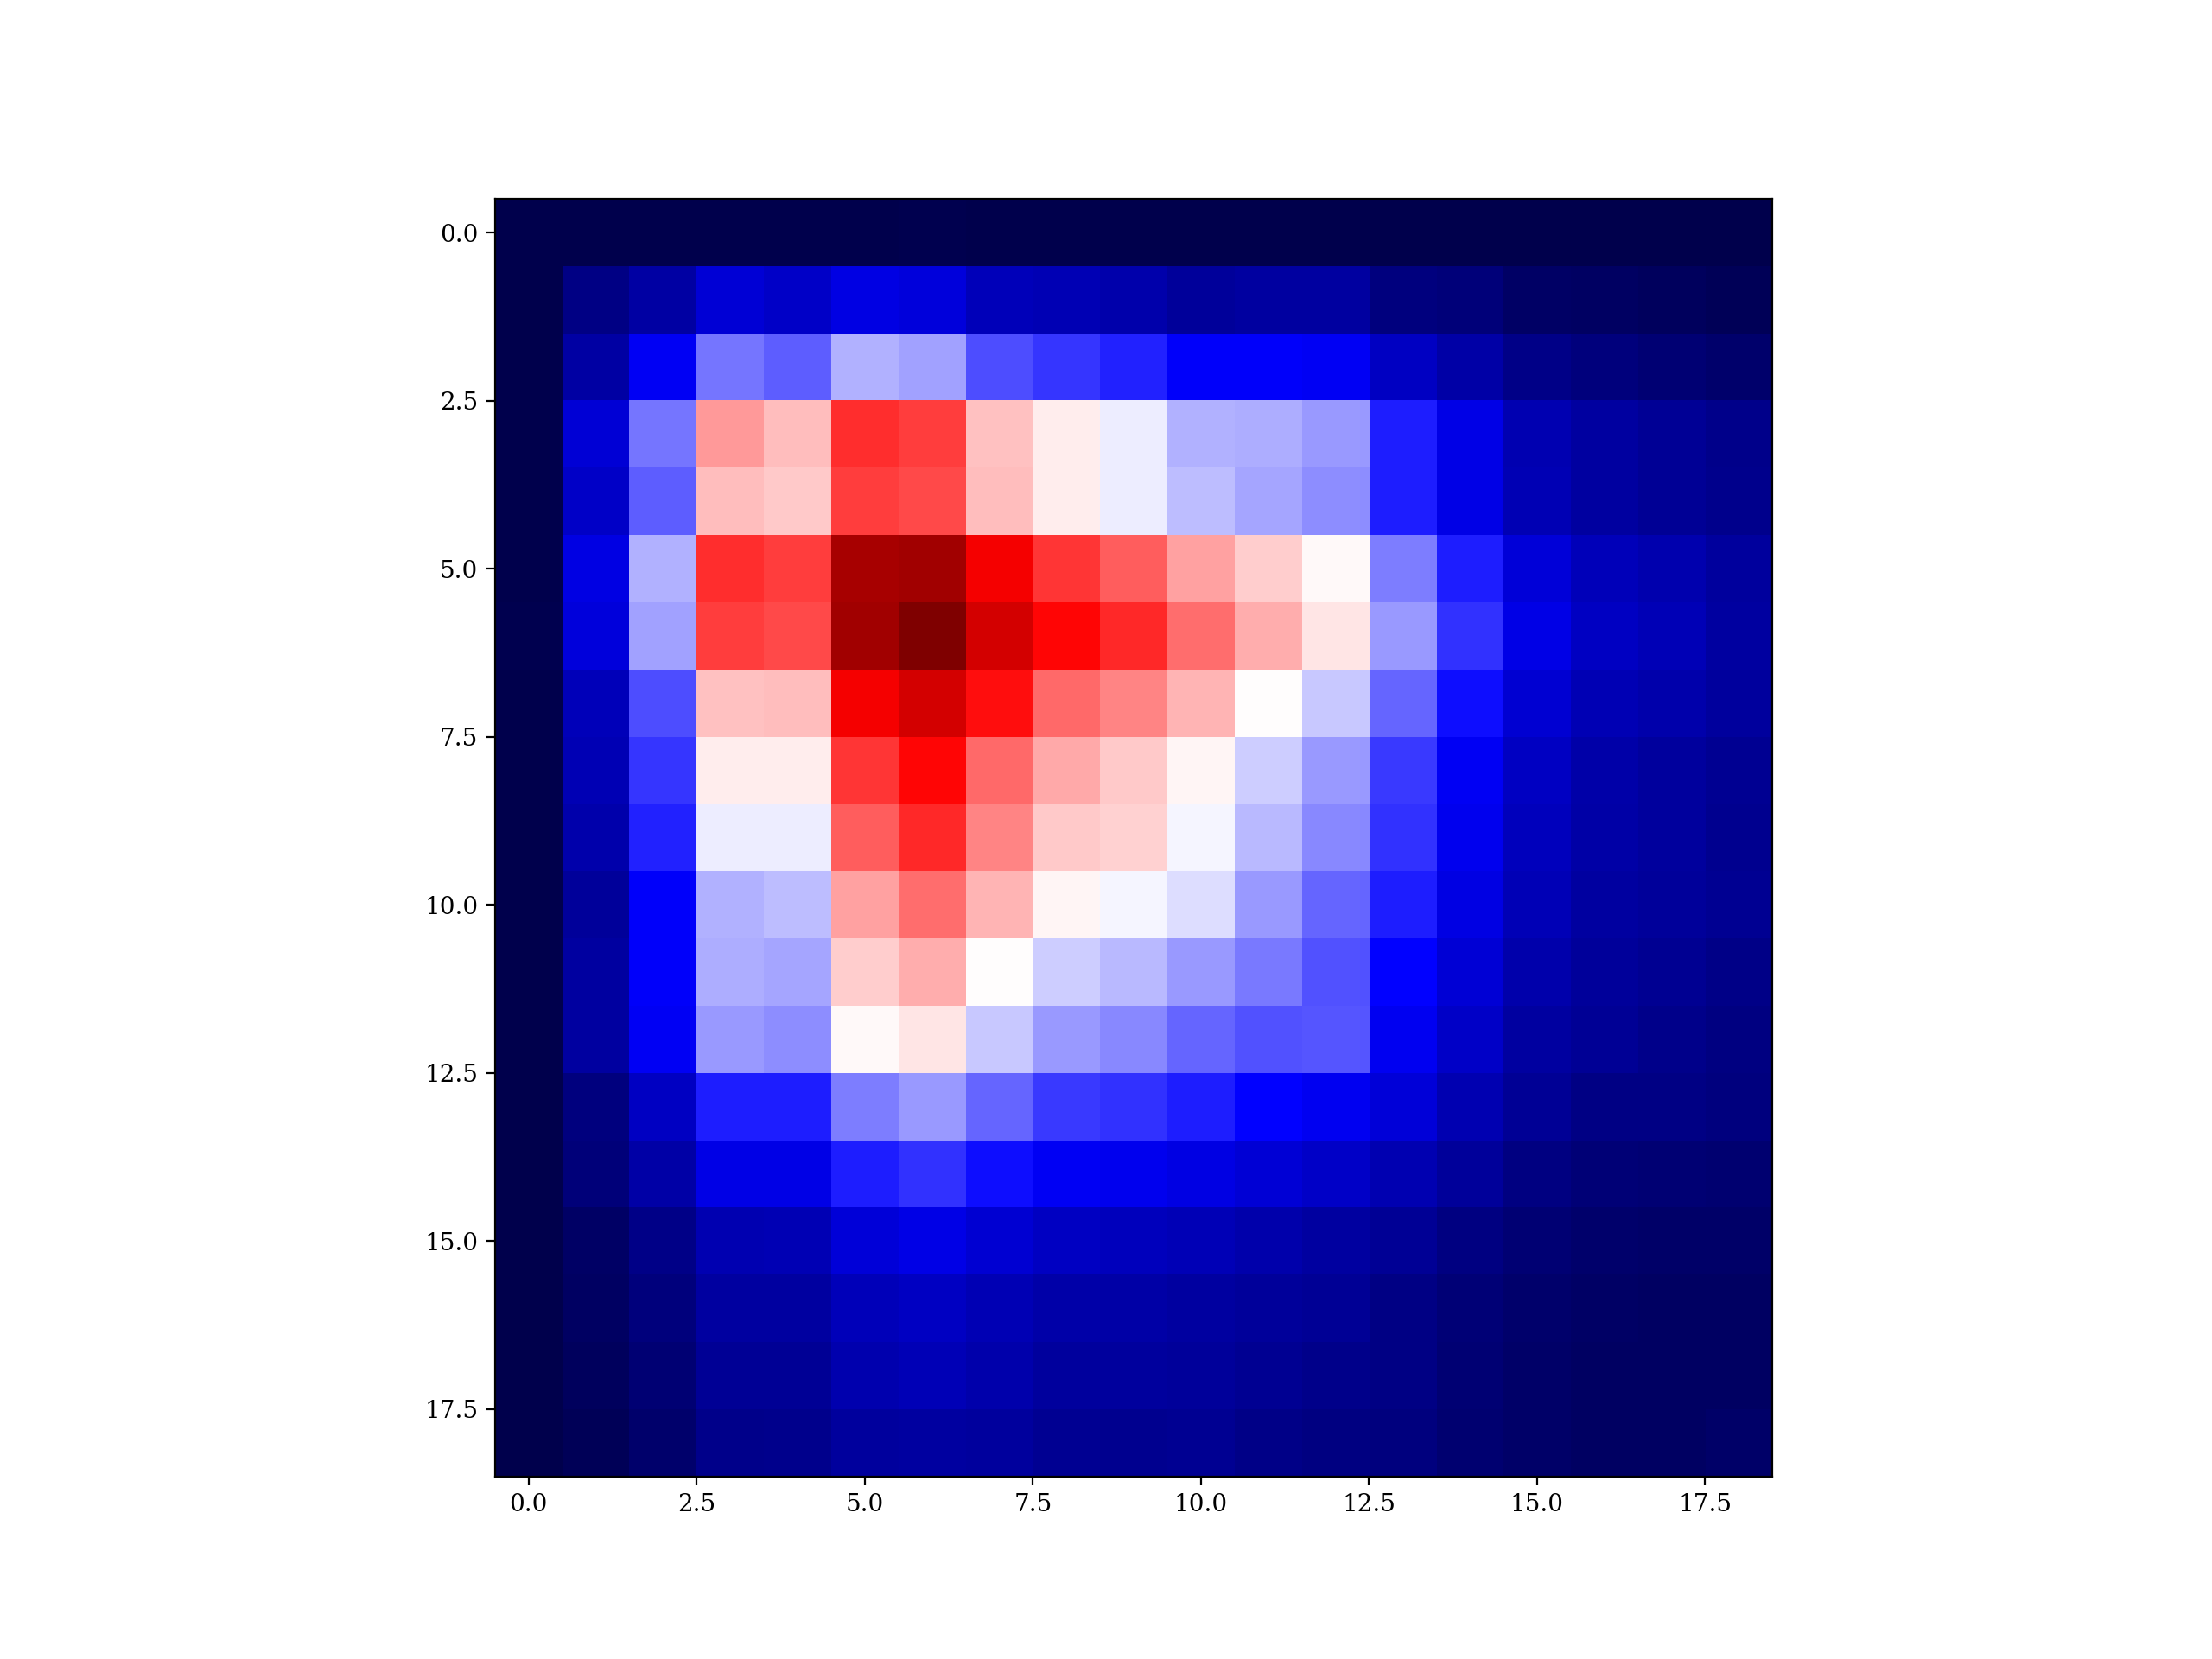

In [14]:
fig = plt.subplots()

#plt.imshow(M_COV,origin={'lower','lower'})
plt.imshow(M_COV_NUMU_SYS)

In [15]:
def GET_PE(exp,m_cov_sys):
    return np.random.poisson(np.clip(np.random.multivariate_normal(exp, m_cov_sys),0,1e9))

In [16]:
def CHI2_SIG(x,data,sig,exp,m_cov_inv):
    return CHI2(data - (x*sig+exp),m_cov_inv)

def FIT_PE_CALC_COND(pe,mu_true):
    exp_cond = COND_EXP(pe[10:]-NUMU_EXP,NUE_EXP,M_COV_NUMU_INV,M_COV_EM)
    m_cov_cond_sys = COND_COV(M_COV_NUE_SYS,np.linalg.inv(M_COV_NUMU_SYS+np.diagflat(pe[10:])),M_COV_ME_SYS,M_COV_EM_SYS)
    m_cov_cond = np.copy(m_cov_cond_sys) + np.diagflat(exp_cond)
    m_cov_cond_inv = np.linalg.inv(m_cov_cond)

    x0 = [0.1]
    res = scipy.optimize.minimize(CHI2_SIG,x0,
                                  args=(pe[:10],SIG_EXP[:10],exp_cond,m_cov_cond_inv),
                                  bounds=[(0,100.)])
    chi2_h0 = CHI2_SIG(0,pe[:10],SIG_EXP[:10],exp_cond,m_cov_cond_inv)
    chi2_hs = CHI2_SIG(1.0,pe[:10],SIG_EXP[:10],exp_cond,m_cov_cond_inv)
    chi2_h1 = CHI2_SIG(mu_true,pe[:10],SIG_EXP[:10],exp_cond,m_cov_cond_inv)
    chi2_hb = CHI2_SIG(res.x[0],pe[:10],SIG_EXP[:10],exp_cond,m_cov_cond_inv)
    chi2_diff = chi2_h1-chi2_hb
    return res.x[0], chi2_h0, chi2_hs, chi2_h1, chi2_hb, chi2_diff

In [17]:
def RUN_PES_FULL(n_pes,mu_true,verbose=False):
    
    tot_exp = DATA_EXP+mu_true*SIG_EXP
    df_pes = pd.DataFrame(index=np.arange(0,n_pes),columns=["mu_true","chi2_h0","chi2_hs","chi2_h1","chi2_hb","chi2_diff","mu_fit","pe_data"])
    
    m_cov_true_inv = M_COV_INV_FAST_FULL(mu_true)
    
    for i_pe in range(int(n_pes)):
        my_pe = GET_PE(tot_exp,M_COV_SYS)
        chi2_h0 = CHI2(my_pe-DATA_EXP,M_COV_INV)
        chi2_hs = CHI2(my_pe-(SIG_EXP+DATA_EXP),M_COV_SIG_INV)
        chi2_h1 = CHI2(my_pe-tot_exp,m_cov_true_inv)
        x0 = [np.max([0.1,mu_true])]
        res = scipy.optimize.minimize(CHI2_SIG_FULL,x0,
                                      args=(my_pe),
                                      bounds=[(0,100.)])
        chi2_hb = CHI2_SIG_FULL(res.x[0],my_pe)
        df_pes.loc[i_pe] = [mu_true,chi2_h0,chi2_hs,chi2_h1,chi2_hb,chi2_h1-chi2_hb,res.x[0],my_pe]
        i_pe+=1
        
        if(i_pe%1000==0 and verbose):
            print("\t\t\t finished PE %d"%i_pe)
        
    return df_pes

def RUN_PES_COND(n_pes,mu_true,verbose=False):
    
    tot_exp = NUE_EXP_COND+mu_true*SIG_EXP_COND
    df_pes = pd.DataFrame(index=np.arange(0,n_pes),columns=["mu_true","chi2_h0","chi2_hs","chi2_h1","chi2_hb","chi2_diff","mu_fit","pe_data"])
    
    m_cov_true_inv = M_COV_INV_FAST_COND(mu_true)
    
    for i_pe in range(int(n_pes)):
        my_pe = GET_PE(tot_exp,M_COV_COND_SYS)
        chi2_h0 = CHI2(my_pe-NUE_EXP_COND,M_COV_COND_INV)
        chi2_hs = CHI2(my_pe-(SIG_EXP_COND+NUE_EXP_COND),M_COV_SIG_COND_INV)
        chi2_h1 = CHI2(my_pe-tot_exp,m_cov_true_inv)
        x0 = [np.max([0.1,mu_true])]
        res = scipy.optimize.minimize(CHI2_SIG_COND,x0,
                                      args=(my_pe),
                                      bounds=[(0,100.)])
        chi2_hb = CHI2_SIG_COND(res.x[0],my_pe)
        df_pes.loc[i_pe] = [mu_true,chi2_h0,chi2_hs,chi2_h1,chi2_hb,chi2_h1-chi2_hb,res.x[0],my_pe]
        i_pe+=1
        
        if(i_pe%1000==0 and verbose):
            print("\t\t\t finished PE %d"%i_pe)
        
    return df_pes

In [18]:
TRUE_VALS = np.arange(0,5.05,0.05)
N_PES = 5e4

In [19]:
CHI2(DATA_OBS-DATA_EXP,M_COV_INV)

63.920378925247995

In [20]:
CHI2(NUMU_OBS-NUMU_EXP,M_COV_NUMU_INV)

40.48557410886951

In [21]:
df_pes_tot = pd.read_hdf("/Users/wketchum/Data/MicroBooNE/LEEFits/fd2_dfs.h5",key="df_pes_tot")
df_pes_cond = pd.read_hdf("/Users/wketchum/Data/MicroBooNE/LEEFits/fd2_dfs.h5",key="df_pes_cond")

In [22]:
SIGMA1 = scipy.stats.norm(0,1).cdf(1)-scipy.stats.norm(0,1).cdf(-1)
SIGMA2 = scipy.stats.norm(0,1).cdf(2)-scipy.stats.norm(0,1).cdf(-2)
SIGMA3 = scipy.stats.norm(0,1).cdf(3)-scipy.stats.norm(0,1).cdf(-3)

In [23]:
def CALC_COND_CHI2(pe):
    nue_exp = COND_EXP(pe[10:]-NUMU_EXP,NUE_EXP,M_COV_NUMU_INV,M_COV_EM)
    m_cov_cond_sys = COND_COV(M_COV_NUE_SYS,M_COV_NUMU_INV,M_COV_ME_SYS,M_COV_EM_SYS)
    return CHI2(pe[:10]-nue_exp,np.linalg.inv(m_cov_cond_sys+np.diagflat(nue_exp)))
def CALC_COND_SIG_CHI2(mu,pe):
    nue_exp = COND_EXP(pe[10:]-NUMU_EXP,NUE_EXP,M_COV_NUMU_INV,M_COV_EM)+mu*SIG_EXP[:10]
    m_cov_cond_sys = COND_COV(M_COV_NUE_SYS,M_COV_NUMU_INV,M_COV_ME_SYS,M_COV_EM_SYS)
    return CHI2(pe[:10]-nue_exp,np.linalg.inv(m_cov_cond_sys+np.diagflat(nue_exp)))

In [24]:
df_pes_tot["mu_fit_cond"], df_pes_tot["chi2_cond_h0"], df_pes_tot["chi2_cond_hs"], df_pes_tot["chi2_cond_h1"], df_pes_tot["chi2_cond_hb"], df_pes_tot["chi2_cond_diff"] = zip(*df_pes_tot.apply(lambda x: FIT_PE_CALC_COND(x["pe_data"],x["mu_true"]), axis=1))

In [25]:
df_pes_tot["chi2_numu"] = df_pes_tot["pe_data"].apply(lambda pe: CHI2(pe[10:]-NUMU_EXP,M_COV_NUMU_INV))

In [26]:
df_pes_tot["chi2_nue"] = df_pes_tot["pe_data"].apply(lambda pe: CHI2(pe[:10]-NUE_EXP,M_COV_NUE_INV))

In [ ]:
df_pes_cond["chi2_nue"] = df_pes_cond["pe_data"].apply(lambda pe: CHI2(pe[:10]-NUE_EXP,M_COV_NUE_INV))

In [27]:
def GET_CRITICAL_VALUES(true_vals,quantiles,df_pes,cond=False):

    critical_vals = np.empty((len(quantiles),len(true_vals)))

    for ix in range(len(true_vals)):
        x = true_vals[ix]
        qstring=str("mu_true>(%f) and mu_true<(%f)"%(x-0.0001,x+0.0001))
        df_pes['mu_true'] = df_pes['mu_true'].astype(float)
        cvals = []
        if not cond:
            cvals = np.quantile(df_pes.query(qstring)["chi2_diff"],quantiles)
        else:
            cvals = np.quantile(df_pes.query(qstring)["chi2_cond_diff"],quantiles)
        
        for iv in range(len(cvals)):
            critical_vals[iv,ix] = cvals[iv]

    return critical_vals

In [34]:
def CHI2_DIFF_FULL(data,x_vals):
    x0 = [0.1]
    res = scipy.optimize.minimize(CHI2_SIG_FULL,x0,
                                  args=(data),
                                        bounds=[(0,100.)])
    chi2_hb_obs = CHI2_SIG_FULL(res.x[0],data=data)
    
    chi2_diff = np.empty(len(x_vals))
    for ix in range(len(x_vals)):
        chi2_diff[ix] = CHI2_SIG_FULL(x_vals[ix],data=data)-chi2_hb_obs
    return chi2_diff

def CHI2_COND_DIFF_FULL(data,x_vals):
    x0 = [0.1]
    res = scipy.optimize.minimize(CALC_COND_SIG_CHI2,x0,
                                  args=(data),
                                        bounds=[(0,100.)])
    chi2_hb_obs = CALC_COND_SIG_CHI2(res.x[0],pe=data)
    
    chi2_diff = np.empty(len(x_vals))
    for ix in range(len(x_vals)):
        chi2_diff[ix] = CALC_COND_SIG_CHI2(x_vals[ix],pe=data)-chi2_hb_obs
    return chi2_diff

def CHI2_DIFF_COND(data,x_vals):
    x0 = [0.1]
    res = scipy.optimize.minimize(CHI2_SIG_COND,x0,
                                  args=(data),
                                        bounds=[(0,100.)])
    chi2_hb_obs = CHI2_SIG_COND(res.x[0],data=data)
    
    chi2_diff = np.empty(len(x_vals))
    for ix in range(len(x_vals)):
        chi2_diff[ix] = CHI2_SIG_COND(x_vals[ix],data=data)-chi2_hb_obs
    return chi2_diff

def GET_FC_INTERVAL(chi2_diff,true_vals,critical_vals):
    intervals = []
    for ic in range(len(critical_vals)):
        vals = np.where(chi2_diff<critical_vals[ic],true_vals,np.nan)
        vals = vals[~np.isnan(vals)]
        if len(vals)==0:
            intervals.append((-1,9999))
        else:
            intervals.append((np.amin(vals),np.amax(vals)))
    return intervals

def CALC_FC_INTERVAL_FULL(data,x_vals,critical_vals):
    return GET_FC_INTERVAL(CHI2_DIFF_FULL(data,x_vals),x_vals,critical_vals)

def CALC_FC_INTERVAL_FULL_CHI2_COND(data,x_vals,critical_vals):
    return GET_FC_INTERVAL(CHI2_COND_DIFF_FULL(data,x_vals),x_vals,critical_vals)

def CALC_FC_INTERVAL_COND(data,x_vals,critical_vals):
    return GET_FC_INTERVAL(CHI2_DIFF_COND(data,x_vals),x_vals,critical_vals)

In [29]:
critical_vals_tot = GET_CRITICAL_VALUES(TRUE_VALS,[SIGMA1,SIGMA2,SIGMA3],df_pes_tot)
critical_vals_tot_chi2_cond = GET_CRITICAL_VALUES(TRUE_VALS,[SIGMA1,SIGMA2,SIGMA3],df_pes_tot,cond=True)

In [30]:
critical_vals_cond = GET_CRITICAL_VALUES(TRUE_VALS,[SIGMA1,SIGMA2,SIGMA3],df_pes_cond)

In [35]:
print(CALC_FC_INTERVAL_FULL(df_pes_tot.iloc[0]["pe_data"],TRUE_VALS,critical_vals_tot))
print(CALC_FC_INTERVAL_FULL_CHI2_COND(df_pes_tot.iloc[0]["pe_data"],TRUE_VALS,critical_vals_tot))
print(CALC_FC_INTERVAL_COND(df_pes_cond.iloc[0]["pe_data"],TRUE_VALS,critical_vals_cond))

[(0.0, 0.1), (0.0, 0.5), (0.0, 1.1500000000000001)]
[(0.0, 0.1), (0.0, 0.55), (0.0, 1.2000000000000002)]
[(0.0, 0.30000000000000004), (0.0, 0.75), (0.0, 1.4000000000000001)]


In [36]:
CALC_FC_INTERVAL_FULL(DATA_OBS,TRUE_VALS,critical_vals_tot)

[(0.45, 1.1), (0.15000000000000002, 1.6500000000000001), (0.0, 2.35)]

In [37]:
CALC_FC_INTERVAL_FULL_CHI2_COND(DATA_OBS,TRUE_VALS,critical_vals_tot)

[(0.45, 1.1), (0.2, 1.6500000000000001), (0.0, 2.35)]

In [38]:
CALC_FC_INTERVAL_COND(NUE_OBS,TRUE_VALS,critical_vals_cond)

[(0.45, 1.1500000000000001), (0.2, 1.6500000000000001), (0.0, 2.35)]

In [ ]:
x0 = [0.1]
res = scipy.optimize.minimize(CHI2_SIG_FULL,x0,
                                  args=(DATA_OBS),
                                        bounds=[(0,100.)])
print(res)

In [ ]:
x0 = [0.1]
res = scipy.optimize.minimize(CHI2_SIG_COND,x0,
                                  args=(NUE_OBS),
                                        bounds=[(0,100.)])
print(res)

In [ ]:
fig,ax = plt.subplots(1,2,sharey=True)

#bins=np.arange(0,50,1)

ax[0].plot(TRUE_VALS,critical_vals_tot[0],label="$1\sigma$")
ax[0].plot(TRUE_VALS,critical_vals_tot[1],label="$2\sigma$")
ax[0].plot(TRUE_VALS,critical_vals_tot[2],label="$3\sigma$")

ax[0].legend()
ax[0].set_ylabel("$\Delta\chi^2$")
ax[0].set_xlabel("Signal Strength")
ax[0].set_title("Full Covariance Matrix")

ax[1].plot(TRUE_VALS,critical_vals_tot[0],label="$1\sigma$")
ax[1].plot(TRUE_VALS,critical_vals_tot[1],label="$2\sigma$")
ax[1].plot(TRUE_VALS,critical_vals_tot[2],label="$3\sigma$")

ax[1].legend()
ax[1].set_ylabel("$\Delta\chi^2$")
ax[1].set_xlabel("Signal Strength")
ax[1].set_title("Conditional Covariance Matrix")

plt.show()
plt.savefig(tmp_plot())

In [ ]:
df_pes_tot["mu_fit"] = df_pes_tot["mu_fit"].astype("float")
df_pes_tot["chi2_diff"] = df_pes_tot["chi2_diff"].astype("float")

df_pes_cond["mu_fit"] = df_pes_cond["mu_fit"].astype("float")
df_pes_cond["chi2_diff"] = df_pes_cond["chi2_diff"].astype("float")

In [ ]:
fig,ax = plt.subplots(int(len(TRUE_VALS)/5),5,sharex=True,sharey=True)
fig.set_size_inches(3*5, 3*int(len(TRUE_VALS)/5))

for itrue in range(len(TRUE_VALS)-1):
    iay=int(itrue/5)
    iax=itrue%5
    
    qstring = "abs(mu_true-%f)<0.001"%TRUE_VALS[itrue]

    res_tot = make_profile_bins(df_pes_tot.query(qstring),0,TRUE_VALS[-1],len(TRUE_VALS),"mu_fit","chi2_diff")
    res_cond = make_profile_bins(df_pes_cond.query(qstring),0,TRUE_VALS[-1],len(TRUE_VALS),"mu_fit","chi2_diff")
    #res_median = make_profile_bins(df_pes_tot.query(qstring),0,TRUE_VALS[-1],len(TRUE_VALS),"mu_fit","chi2_diff",func="median")


    ax[iay][iax].plot(res_tot["x"],res_tot["y"],color='k')
    ax[iay][iax].plot(res_cond["x"],res_cond["y"],color='b')
    #ax.plot(res_median["x"],res_median["median"],color='k',linestyle="-.")
    ax[iay][iax].hlines(xmin=0,xmax=TRUE_VALS[-1],y=critical_vals_cond[0][itrue],color='blue',linestyle="--",label="")
    ax[iay][iax].hlines(xmin=0,xmax=TRUE_VALS[-1],y=critical_vals_cond[1][itrue],color='blue',linestyle="--",label="")
    ax[iay][iax].hlines(xmin=0,xmax=TRUE_VALS[-1],y=critical_vals_cond[2][itrue],color='blue',linestyle="--",label="")
    ax[iay][iax].hlines(xmin=0,xmax=TRUE_VALS[-1],y=critical_vals_tot[0][itrue],color='k',linestyle="--",label="")
    ax[iay][iax].hlines(xmin=0,xmax=TRUE_VALS[-1],y=critical_vals_tot[1][itrue],color='k',linestyle="--",label="")
    ax[iay][iax].hlines(xmin=0,xmax=TRUE_VALS[-1],y=critical_vals_tot[2][itrue],color='k',linestyle="--",label="")
    #ax[iay][iax].set_ylim(bottom=0,top=critical_vals_cond[2][itrue]+10)

    #plt.legend()
    ax[iay][iax].set_ylabel("$\Delta\chi^2$")
    ax[iay][iax].set_xlabel("$\mu_{fit}$")
    ax[iay][iax].set_title("$\mu_{true}=%1.1f$"%TRUE_VALS[itrue])

plt.setp(ax, ylim=(0,20))
plt.tight_layout()
#plt.subplots_adjust(bottom=0.2,top=0.8)
plt.show()
plt.savefig(tmp_plot())

In [ ]:
fig,ax = plt.subplots(1,2)
fig.set_size_inches(8, 6)

bins=np.arange(0,200,1)

ax[0].hist(df_pes_tot.query("abs(mu_true-0.0)<0.001")["chi2_h0"],bins=bins,label="$\mu_{true}=0.0$",histtype="step",log=True)
ax[0].hist(df_pes_tot.query("abs(mu_true-1.0)<0.001")["chi2_h0"],bins=bins,label="$\mu_{true}=1.0$",histtype="step",log=True)
ax[0].vlines(x=CHI2_SIG_FULL(0,DATA_OBS),ymin=0,ymax=5e3,color="r")

ax[0].set_xlabel("$\chi^2_{SM}$")
ax[0].set_ylabel("$N_{PEs}$")
ax[0].set_title("Full Covariance Matrix")

bins2=np.arange(0,120,1)

ax[1].hist(df_pes_cond.query("abs(mu_true-0.0)<0.001")["chi2_h0"],bins=bins2,label="$\mu_{true}=0.0$",histtype="step",log=True)
ax[1].hist(df_pes_cond.query("abs(mu_true-1.0)<0.001")["chi2_h0"],bins=bins2,label="$\mu_{true}=1.0$",histtype="step",log=True)
ax[1].vlines(x=CHI2_SIG_COND(0,NUE_OBS),ymin=0,ymax=5e3,color="r")

ax[1].set_xlabel("$\chi^2_{SM}$")
ax[1].set_ylabel("$N_{PEs}$")
ax[1].set_title("Conditional Covariance Matrix")

plt.show()
plt.savefig(tmp_plot())

In [ ]:
fig,ax = plt.subplots(1,2)
fig.set_size_inches(8, 6)

bins=np.arange(0,40,1)

ax[0].hist(df_pes_tot.query("abs(mu_true-0.0)<0.001")["chi2_diff"],bins=bins,label="$\mu_{true}=0.0$",histtype="step",log=True)
ax[0].vlines(x=CHI2_DIFF_FULL(DATA_OBS,[0]),ymin=0,ymax=1000,color="r")

ax[0].set_xlabel("$\Delta\chi^2_{SM}$")
ax[0].set_ylabel("$N_{PEs}$")
ax[0].set_title("Full Covariance Matrix")

bins2=np.arange(0,40,1)

ax[1].hist(df_pes_cond.query("abs(mu_true-0.0)<0.001")["chi2_diff"],bins=bins2,label="$\mu_{true}=0.0$",histtype="step",log=True)
ax[1].vlines(x=CHI2_DIFF_COND(NUE_OBS,[0]),ymin=0,ymax=1000,color="r")

ax[1].set_xlabel("$\Delta\chi^2_{SM}$")
ax[1].set_ylabel("$N_{PEs}$")
ax[1].set_title("Conditional Covariance Matrix")

plt.show()
plt.savefig(tmp_plot())

In [ ]:
CALC_COND_CHI2(DATA_OBS)-CALC_COND_SIG_CHI2(DATA_OBS,1.0)

In [ ]:
df_pes_tot_tmp

In [ ]:
fig,ax = plt.subplots(1,1)

bins=np.arange(0,8,0.1)

ax.hist(df_pes_tot.query("abs(mu_true-0.0)<0.001")["chi2_h0"]/len(DATA_EXP),bins=bins,label="Full, $\mu=0.0$",histtype="step",color='k')
ax.hist(df_pes_tot.query("abs(mu_true-0.0)<0.001")["chi2_cond"]/len(NUE_EXP),bins=bins,label="Conditional, $\mu=0.0$",histtype="step",color='k',linestyle="--")
ax.hist(df_pes_tot.query("abs(mu_true-1.0)<0.001")["chi2_h0"]/len(DATA_EXP),bins=bins,label="Full, $\mu=1.0$",histtype="step",color='b')
ax.hist(df_pes_tot.query("abs(mu_true-1.0)<0.001")["chi2_cond"]/len(NUE_EXP),bins=bins,label="Conditional, $\mu=1.0$",histtype="step",color='b',linestyle="--")
ax.hist(df_pes_cond.query("abs(mu_true-0.0)<0.001")["chi2_h0"]/len(NUE_EXP),bins=bins,label="Full, $\mu=1.0$",histtype="step",color='k',linestyle="dotted")
ax.hist(df_pes_cond.query("abs(mu_true-1.0)<0.001")["chi2_h0"]/len(NUE_EXP),bins=bins,label="Conditional, $\mu=1.0$",histtype="step",color='b',linestyle="dotted")
#ax[0].vlines(x=CHI2_DIFF_FULL(DATA_OBS,[0]),ymin=0,ymax=1000,color="r")

ax.set_xlabel("$\chi^2_{SM}$/d.o.f")
ax.set_ylabel("$N_{PEs}$")

#ax[0].set_title("Full Covariance Matrix")
plt.legend()
plt.show()
plt.savefig(tmp_plot())

In [ ]:
fig,ax = plt.subplots(2)

bins=np.arange(0,60,1)

ax[0].hist(df_pes_cond.query("abs(mu_true-0.0)<0.001")["chi2_h0"],bins=bins,label="PEs from Conditional $\mu=0.0$",histtype="step",color='k')
ax[0].hist(df_pes_tot.query("abs(mu_true-0.0)<0.001")["chi2_cond"],bins=bins,label="PEs from full, $\mu=0.0$",histtype="step",color='b')
ax[0].hist(df_pes_cond.query("abs(mu_true-1.0)<0.001")["chi2_h0"],bins=bins,label="PEs from Conditional $\mu=1.0$",histtype="step",color='k',linestyle="--")
ax[0].hist(df_pes_tot.query("abs(mu_true-1.0)<0.001")["chi2_cond"],bins=bins,label="PEs from full, $\mu=1.0$",histtype="step",color='b',linestyle="--")
#ax[0].vlines(x=CHI2_DIFF_FULL(DATA_OBS,[0]),ymin=0,ymax=1000,color="r")

ax[0].set_xlabel("$\chi^2_{SM}$")
ax[0].set_ylabel("$N_{PEs}$")
ax[0].legend()

bins2=np.arange(0,10,0.1)

ax[1].hist(df_pes_cond.query("abs(mu_true-0.0)<0.001")["chi2_diff"],bins=bins2,label="PEs from Conditional $\mu=0.0$",histtype="step",color='k')
ax[1].hist(df_pes_tot.query("abs(mu_true-0.0)<0.001")["chi2_diff"],bins=bins2,label="PEs from full, $\mu=0.0$",histtype="step",color='b')
ax[1].hist(df_pes_cond.query("abs(mu_true-1.0)<0.001")["chi2_diff"],bins=bins2,label="PEs from Conditional $\mu=1.0$",histtype="step",color='k',linestyle="--",log=True)
ax[1].hist(df_pes_tot.query("abs(mu_true-1.0)<0.001")["chi2_diff"],bins=bins2,label="PEs from full, $\mu=1.0$",histtype="step",color='b',linestyle="--",log=True)

ax[1].set_xlabel("$\Delta\chi^2_{SM}$")
ax[1].set_ylabel("$N_{PEs}$")


#ax[0].set_title("Full Covariance Matrix")
ax[1].legend()
plt.tight_layout()
plt.show()
plt.savefig(tmp_plot())

In [ ]:
fig,ax = plt.subplots()

bins=np.arange(0,80,1)

ax.hist(df_pes_tot.query("abs(mu_true-0.0)<0.001")["chi2_numu"],bins=bins,label="H0 PEs",histtype="step",log=True)
ax.vlines(x=CHI2(NUMU_OBS-NUMU_EXP,M_COV_NUMU_INV),ymin=0,ymax=1000,color="r",label="Select PE (Fake Data)")

ax.set_xlabel("$\chi^2_{\mu}$")
ax.set_ylabel("$N_{PEs}$")
ax.legend()

plt.show()
plt.savefig(tmp_plot(ftype="png"))

In [ ]:
print(NUMU_OBS)
print(NUMU_EXP)
print((NUMU_OBS-NUMU_EXP)/NUMU_EXP)
print(CHI2(NUMU_OBS[1:]-NUMU_EXP[1:],np.linalg.inv(M_COV_NUMU[1:,1:])))
#print(M_COV_NUMU_SYS)

chi2_sum=0
for i in range(len(NUMU_OBS)):
    chi2_sum += (NUMU_OBS[i]-NUMU_EXP[i])*(NUMU_OBS[i]-NUMU_EXP[i])/np.sqrt(M_COV_NUMU[i][i])
print(chi2_sum)

In [ ]:
fig,ax = plt.subplots()

bins=np.arange(0,40,1)

ax.hist(df_pes_tot.query("abs(mu_true-0.0)<0.001")["chi2_nue"],bins=bins,label="Full PEs, Original $\chi^2$",color='b',histtype="step",log=True)
ax.hist(df_pes_tot.query("abs(mu_true-0.0)<0.001")["chi2_cond"],bins=bins,label="Full PEs, Conditional $\chi^2$",color='b',histtype="step",log=True,linestyle="dashed")
#ax.vlines(x=CHI2(NUE_OBS-NUE_EXP,M_COV_NUE_INV),ymin=0,ymax=3000,color="r",label="Select PE (Fake Data), Original $\chi^2$")
#ax.vlines(x=CHI2(NUE_OBS-NUE_EXP_COND,M_COV_COND_INV),ymin=0,ymax=3000,color="r",label="Select PE (Fake Data), Conditional $\chi^2$",linestyle="dashed")

ax.set_xlabel("$\chi^2_{e}$")
ax.set_ylabel("$N_{PEs}$")
ax.legend()

plt.show()
plt.savefig(tmp_plot(ftype="png"))

In [ ]:
fig,ax = plt.subplots()

bins=np.arange(0,40,1)

ax.hist(df_pes_tot.query("abs(mu_true-0.0)<0.001")["chi2_nue"],bins=bins,label="Full PEs, Original $\chi^2$",color='b',histtype="step")
ax.hist(df_pes_tot.query("abs(mu_true-0.0)<0.001")["chi2_cond"],bins=bins,label="Full PEs, Conditional $\chi^2$",color='b',histtype="step",linestyle="dashed")
ax.hist(df_pes_cond.query("abs(mu_true-0.0)<0.001")["chi2_nue"],bins=bins,label="Constrained PEs, Original $\chi^2$",color='g',histtype="step")
ax.hist(df_pes_cond.query("abs(mu_true-0.0)<0.001")["chi2_h0"],bins=bins,label="Constrained PEs, Conditional $\chi^2$",color='g',histtype="step",linestyle="dashed")
#ax.vlines(x=CHI2(NUE_OBS-NUE_EXP,M_COV_NUE_INV),ymin=0,ymax=3000,color="r",label="Select PE (Fake Data), Original $\chi^2$")
#ax.vlines(x=CHI2(NUE_OBS-NUE_EXP_COND,M_COV_COND_INV),ymin=0,ymax=3000,color="r",label="Select PE (Fake Data), Conditional $\chi^2$",linestyle="dashed")

ax.set_xlabel("$\chi^2_{e}$")
ax.set_ylabel("$N_{PEs}$")
ax.legend()

plt.show()
plt.savefig(tmp_plot(ftype="png"))

In [ ]:
fig,ax = plt.subplots()

bins=np.arange(0,200,4)

ax.hist(df_pes_tot.query("abs(mu_true-2.0)<0.001")["chi2_nue"],bins=bins,label="Full PEs, Original $\chi^2$",color='b',histtype="step")
ax.hist(df_pes_tot.query("abs(mu_true-2.0)<0.001")["chi2_cond"],bins=bins,label="Full PEs, Conditional $\chi^2$",color='b',histtype="step",linestyle="dashed")
ax.hist(df_pes_cond.query("abs(mu_true-2.0)<0.001")["chi2_nue"],bins=bins,label="Constrained PEs, Original $\chi^2$",color='g',histtype="step")
ax.hist(df_pes_cond.query("abs(mu_true-2.0)<0.001")["chi2_h0"],bins=bins,label="Constrained PEs, Conditional $\chi^2$",color='g',histtype="step",linestyle="dashed")
#ax.vlines(x=CHI2(NUE_OBS-NUE_EXP,M_COV_NUE_INV),ymin=0,ymax=3000,color="r",label="Select PE (Fake Data), Original $\chi^2$")
#ax.vlines(x=CHI2(NUE_OBS-NUE_EXP_COND,M_COV_COND_INV),ymin=0,ymax=3000,color="r",label="Select PE (Fake Data), Conditional $\chi^2$",linestyle="dashed")

ax.set_xlabel("$\chi^2_{e}$")
ax.set_ylabel("$N_{PEs}$")
ax.legend()

plt.title("x2 eLEE signal")
plt.show()
plt.savefig(tmp_plot(ftype="png"))

In [ ]:
df_pes_tot_diff0s = df_pes_tot[["mu_true","chi2_h0","chi2_hs","chi2_cond","chi2_cond_sig1","chi2_cond2","chi2_cond2_sig1"]]
df_pes_tot_diff0s["chi2_diff0s"]=df_pes_tot_diff0s["chi2_h0"]-df_pes_tot_diff0s["chi2_hs"]
df_pes_tot_diff0s["chi2_cond_diff0s"]=df_pes_tot_diff0s["chi2_cond"]-df_pes_tot_diff0s["chi2_cond_sig1"]
df_pes_tot_diff0s["chi2_cond2_diff0s"]=df_pes_tot_diff0s["chi2_cond2"]-df_pes_tot_diff0s["chi2_cond2_sig1"]

df_pes_cond_diff0s = df_pes_cond[["mu_true","chi2_h0","chi2_hs"]]
df_pes_cond_diff0s["chi2_diff0s"]=df_pes_cond_diff0s["chi2_h0"]-df_pes_cond_diff0s["chi2_hs"]

fd_chi2_diff0s = CHI2(DATA_OBS-DATA_EXP,M_COV_INV)-CHI2_SIG_FULL(1.0,DATA_OBS)
fd_chi2_cond_diff0s = CHI2(NUE_OBS-NUE_EXP_COND,M_COV_COND_INV)-CHI2_SIG_COND(1.0,NUE_OBS)
fd_chi2_cond2_diff0s = CHI2(NUE_OBS-NUE_EXP_COND,M_COV_COND2_INV)-CALC_COND2_SIG_CHI2(DATA_OBS,1.0)

n_chi2_h0_diff0s = df_pes_tot_diff0s.query("abs(mu_true-0.0)<0.001 and chi2_diff0s>%f"%fd_chi2_diff0s)["mu_true"].count()
n_chi2_cond_h0_diff0s_fullpe = df_pes_tot_diff0s.query("abs(mu_true-0.0)<0.001 and chi2_cond_diff0s>%f"%fd_chi2_cond_diff0s)["mu_true"].count()
n_chi2_cond2_h0_diff0s_fullpe = df_pes_tot_diff0s.query("abs(mu_true-0.0)<0.001 and chi2_cond2_diff0s>%f"%fd_chi2_cond2_diff0s)["mu_true"].count()
n_chi2_cond_h0_diff0s_condpe = df_pes_cond_diff0s.query("abs(mu_true-0.0)<0.001 and chi2_diff0s>%f"%fd_chi2_cond_diff0s)["mu_true"].count()

print(n_chi2_h0_diff0s,n_chi2_cond_h0_diff0s_fullpe,n_chi2_cond2_h0_diff0s_fullpe,n_chi2_cond_h0_diff0s_condpe)
print(n_chi2_h0_diff0s/5e4,n_chi2_cond_h0_diff0s_fullpe/5e4,n_chi2_cond2_h0_diff0s_fullpe/5e4,n_chi2_cond_h0_diff0s_condpe/5e4)

In [ ]:
CHI2(NUE_OBS-NUE_EXP_COND,M_COV_COND2_INV)
#print(NUE_OBS)

In [ ]:
fig,ax = plt.subplots()
fig.set_size_inches(10,5)
bins=np.arange(-20,80,2)

ax.hist(df_pes_tot.query("abs(mu_true-0.0)<0.001")["chi2_h0"]-df_pes_tot.query("abs(mu_true-0.0)<0.001")["chi2_hs"],bins=bins,label="Full PEs, Full $\chi^2$, No eLEE",color='b',histtype="step",linestyle="dotted")
ax.hist(df_pes_tot.query("abs(mu_true-0.0)<0.001")["chi2_cond2"]-df_pes_tot.query("abs(mu_true-0.0)<0.001")["chi2_cond2_sig1"],bins=bins,label="Full PEs, Cond. $\chi^2$, No eLEE",color='r',histtype="step",linestyle="dotted")
ax.hist(df_pes_cond.query("abs(mu_true-0.0)<0.001")["chi2_h0"]-df_pes_cond.query("abs(mu_true-0.0)<0.001")["chi2_hs"],bins=bins,label="Cond. PEs, Cond. $\chi^2$, No eLEE",color='g',histtype="step",linestyle="dotted")
ax.hist(df_pes_tot.query("abs(mu_true-1.0)<0.001")["chi2_h0"]-df_pes_tot.query("abs(mu_true-1.0)<0.001")["chi2_hs"],bins=bins,label="Full PEs, Full $\chi^2$, x1.0 eLEE",color='b',histtype="step")
ax.hist(df_pes_tot.query("abs(mu_true-1.0)<0.001")["chi2_cond2"]-df_pes_tot.query("abs(mu_true-1.0)<0.001")["chi2_cond2_sig1"],bins=bins,label="Full PEs, Cond. $\chi^2$, x1.0 eLEE",color='r',histtype="step")
ax.hist(df_pes_cond.query("abs(mu_true-1.0)<0.001")["chi2_h0"]-df_pes_cond.query("abs(mu_true-1.0)<0.001")["chi2_hs"],bins=bins,label="Cond. PEs, Cond. $\chi^2$, x1.0 eLEE",color='g',histtype="step")



ax.vlines(x=(CHI2(DATA_OBS-DATA_EXP,M_COV_INV)-CHI2_SIG_FULL(1.0,DATA_OBS)),ymin=0,ymax=10000,color="b",label="FD2, Full PEs, Full $\chi^2$ ($p_{SM}$=%f)"%(n_chi2_h0_diff0s/5e4))
ax.vlines(x=fd_chi2_cond2_diff0s,ymin=0,ymax=10000,color="r",label="FD2, Full PEs, Cond. $\chi^2$ ($p_{SM}$=%f)"%(n_chi2_cond2_h0_diff0s_fullpe/5e4))
ax.vlines(x=(CHI2(NUE_OBS-NUE_EXP_COND,M_COV_COND_INV)-CHI2_SIG_COND(1.0,NUE_OBS)),ymin=0,ymax=10000,color="g",linestyle="--",label="FD2, Cond. PEs, Cond. $\chi^2$ ($p_{SM}$=%f)"%(n_chi2_cond_h0_diff0s_condpe/5e4))

#ax.vlines(x=CHI2(NUE_OBS-NUE_EXP_COND,M_COV_COND_INV),ymin=0,ymax=3000,color="r",label="Select PE (Fake Data), Conditional $\chi^2$",linestyle="dashed")

ax.set_xlabel("$\chi^2_{SM} - \chi^2_{eLEE}$")
ax.set_ylabel("$N_{PEs}$")
ax.legend()

#plt.title("x2 eLEE signal")
plt.show()
plt.savefig(tmp_plot(ftype="png"))

In [ ]:
df_pes_tot_diff0s["chi2_diff0s_diff"] = df_pes_tot_diff0s["chi2_diff0s"] - df_pes_tot_diff0s["chi2_cond_diff0s"]
df_pes_tot_diff0s["chi2_diff0s_diff"] = df_pes_tot_diff0s["chi2_diff0s_diff"].astype("float")
df_pes_tot_diff0s.query("abs(mu_true-0.0)<0.001 and abs(chi2_diff0s_diff)>5")

In [ ]:
fig,ax = plt.subplots()

bins=np.arange(0,3.0,0.2)

ax.hist(df_pes_tot.query("abs(mu_true-0.0)<0.001")["mu_fit"],bins=bins,label="Full PEs, No eLEE",color='b',histtype="step",linestyle="dotted")
ax.hist(df_pes_cond.query("abs(mu_true-0.0)<0.001")["mu_fit"],bins=bins,label="Conditional PEs, No eLEE",color='g',histtype="step",linestyle="dotted")
ax.hist(df_pes_tot.query("abs(mu_true-1.0)<0.001")["mu_fit"],bins=bins,label="Full PEs, x1 eLEE",color='b',histtype="step")
ax.hist(df_pes_cond.query("abs(mu_true-1.0)<0.001")["mu_fit"],bins=bins,label="Conditional PEs, x1 eLEE",color='g',histtype="step")
#ax.hist(df_pes_tot.query("abs(mu_true-0.0)<0.001")["chi2_cond"],bins=bins,label="Full PEs, Conditional $\chi^2$",color='b',histtype="step",linestyle="dashed")
#ax.hist(df_pes_cond.query("abs(mu_true-2.0)<0.001")["chi2_hb"],bins=bins,label="Constrained PEs, Original $\chi^2$",color='g',histtype="step")
#ax.hist(df_pes_cond.query("abs(mu_true-2.0)<0.001")["chi2_h0"],bins=bins,label="Constrained PEs, Conditional $\chi^2$",color='g',histtype="step",linestyle="dashed")
#ax.vlines(x=CHI2(NUE_OBS-NUE_EXP,M_COV_NUE_INV),ymin=0,ymax=3000,color="r",label="Select PE (Fake Data), Original $\chi^2$")
#ax.vlines(x=CHI2(NUE_OBS-NUE_EXP_COND,M_COV_COND_INV),ymin=0,ymax=3000,color="r",label="Select PE (Fake Data), Conditional $\chi^2$",linestyle="dashed")

ax.set_xlabel("Best fit eLEE Signal Strength")
ax.set_ylabel("$N_{PEs}$")
ax.legend()

#plt.title("x2 eLEE signal")
plt.show()
plt.savefig(tmp_plot(ftype="png"))

In [ ]:
fig,ax = plt.subplots(1,2)

bins=np.arange(0,30,1)

ax[0].hist(df_pes_tot.query("abs(mu_true-0.0)<0.001")["chi2_nue"],bins=bins,label="PEs From Full",histtype="step")
ax[0].hist(df_pes_tot.query("abs(mu_true-0.0)<0.001")["chi2_cond"],bins=bins,label="PEs From Full",histtype="step",color='b',linestyle='--')
ax[0].hist(df_pes_cond.query("abs(mu_true-0.0)<0.001")["chi2_nue"],bins=bins,label="PEs From Constrained",histtype="step",linestyle='--')
ax[0].hist(df_pes_cond.query("abs(mu_true-0.0)<0.001")["chi2_h0"],bins=bins,label="PEs From Constrained",histtype="step",color='g')
#ax.vlines(x=CHI2(NUMU_OBS-NUMU_EXP,M_COV_NUMU_INV),ymin=0,ymax=1000,color="r")

ax[0].set_xlabel("$\chi^2_{e}$")
ax[0].set_ylabel("$N_{PEs}$")

bins2=np.arange(0,160,4)

ax[1].hist(df_pes_tot.query("abs(mu_true-2.0)<0.001")["chi2_nue"],bins=bins2,label="PEs From Full",histtype="step")
ax[1].hist(df_pes_tot.query("abs(mu_true-2.0)<0.001")["chi2_cond"],bins=bins2,label="PEs From Full",histtype="step",color='b',linestyle='--')
ax[1].hist(df_pes_cond.query("abs(mu_true-2.0)<0.001")["chi2_nue"],bins=bins2,label="PEs From Constrained",histtype="step",linestyle='--')
ax[1].hist(df_pes_cond.query("abs(mu_true-2.0)<0.001")["chi2_h0"],bins=bins2,label="PEs From Constrained",histtype="step",color='g')
#ax.vlines(x=CHI2(NUMU_OBS-NUMU_EXP,M_COV_NUMU_INV),ymin=0,ymax=1000,color="r")

ax[1].set_xlabel("$\chi^2_{e}$")
ax[1].set_ylabel("$N_{PEs}$")

plt.show()
plt.savefig(tmp_plot())

In [ ]:
print(SIG_EXP_COND/SIG_EXP[:10])
print(SIG_EXP[:10])

In [ ]:
chi2(nue_obs-nue_exp_cond,np.linalg.inv(m_cov_cond))

In [ ]:
print(nue_exp_cond)
print(m_cov_cond)
print(m_cov_cond_sys)

In [ ]:
for i in range(20):
    my_pe = get_pe(nue_exp_cond, m_cov_cond_sys)
    print(my_pe)
    print(chi2(my_pe-nue_exp_cond,np.linalg.inv(m_cov_cond)))

In [ ]:
df_pes_cond = pd.DataFrame()
for x in true_vals:
    print("\tRunning x=%f"%x)
    df_pes_cond = df_pes_cond.append(run_pes(n_pes,x,nue_exp_cond,sig_exp_cond[:10],m_cov_cond_sys))

In [ ]:
df_pes_cond

In [ ]:
df_pes_tot

In [ ]:
def get_fc_interval(chi2_diff,true_vals,critical_vals):
    vals = np.where(chi2_diff<critical_vals,true_vals,np.nan)
    vals = vals[~np.isnan(vals)]
    return (np.amin(vals),np.amax(vals),vals)
def get_fc_interval_min(chi2_diff,true_vals,critical_vals):
    vals = np.where(chi2_diff<critical_vals,true_vals,np.nan)
    vals = vals[~np.isnan(vals)]
    if len(vals)==0:
        return -1
    return np.amin(vals)
def get_fc_interval_max(chi2_diff,true_vals,critical_vals):
    vals = np.where(chi2_diff<critical_vals,true_vals,np.nan)
    vals = vals[~np.isnan(vals)]
    if len(vals)==0:
        return 9999
    return np.amax(vals)

In [ ]:
def chi2_diff(data,x_vals,sig,bkg,m_cov_inv):
    x0 = [0.1]
    res = scipy.optimize.minimize(chi2_sig,x0,
                                  args=(data,
                                        sig,
                                        bkg,
                                        m_cov_inv),
                                        bounds=[(0,100.)])
    chi2_hb_obs = chi2_sig(res.x[0],data=data,sig=sig,bkg=bkg,m_cov_inv=m_cov_inv)
    
    chi2_diff = np.empty(len(x_vals))
    for ix in range(len(x_vals)):
        chi2_diff[ix] = chi2_sig(x_vals[ix],data=data,sig=sig,bkg=bkg,m_cov_inv=m_cov_inv)-chi2_hb_obs
    return chi2_diff


In [ ]:
df_tmp

In [ ]:
def add_fc_intervals(df_pes,x_vals,critical_vals,sig,bkg,m_cov_inv):
    df_pes["fc_interval_min_s1"] = df_pes["pe_data"].apply(lambda pe: get_fc_interval_min(chi2_diff(pe,x_vals,sig,bkg,m_cov_inv),x_vals,critical_vals[0]))
    df_pes["fc_interval_max_s1"] = df_pes["pe_data"].apply(lambda pe: get_fc_interval_max(chi2_diff(pe,x_vals,sig,bkg,m_cov_inv),x_vals,critical_vals[0]))
    df_pes["fc_interval_min_s2"] = df_pes["pe_data"].apply(lambda pe: get_fc_interval_min(chi2_diff(pe,x_vals,sig,bkg,m_cov_inv),x_vals,critical_vals[1]))
    df_pes["fc_interval_max_s2"] = df_pes["pe_data"].apply(lambda pe: get_fc_interval_max(chi2_diff(pe,x_vals,sig,bkg,m_cov_inv),x_vals,critical_vals[1]))
    #df_pes["fc_interval_min_s3"] = df_pes["pe_data"].apply(lambda pe: get_fc_interval_min(chi2_diff(pe,x_vals,sig,bkg,m_cov_inv),x_vals,critical_vals[2]))
    #df_pes["fc_interval_max_s3"] = df_pes["pe_data"].apply(lambda pe: get_fc_interval_max(chi2_diff(pe,x_vals,sig,bkg,m_cov_inv),x_vals,critical_vals[2]))
    
    df_pes["true_contained_s1"] = np.logical_and(df_pes["mu_true"]>=df_pes["fc_interval_min_s1"],
                                                 df_pes["mu_true"]<=df_pes["fc_interval_max_s1"])
    df_pes["true_contained_s2"] = np.logical_and(df_pes["mu_true"]>=df_pes["fc_interval_min_s2"],
                                                 df_pes["mu_true"]<=df_pes["fc_interval_max_s2"])
    #df_pes["true_contained_s3"] = np.logical_and(df_pes["mu_true"]>=df_pes["fc_interval_min_s3"],
    #                                             df_pes["mu_true"]<=df_pes["fc_interval_max_s3"])
    return df_pes

In [ ]:
diff_obs = chi2_diff(df_pes_tot.iloc[1]["pe_data"],true_vals,sig_exp,data_exp,m_cov_inv)

In [ ]:
for cval in critical_vals_tot:
    print(get_fc_interval(diff_obs,true_vals,cval))

In [ ]:
df_tmp = df_pes_tot.iloc[:10].copy()

In [ ]:
df_pes_tot = add_fc_intervals(df_pes_tot,true_vals,critical_vals_tot,sig_exp,data_exp,m_cov_inv)

In [ ]:
df_pes_cond["intervals"] = df_pes_cond["pe_data"].apply(lambda pe: calc_fc_interval_numba(pe,true_vals,sig_exp[:10],nue_exp_cond,np.linalg.inv(m_cov_cond),critical_vals_cond))

In [ ]:
df_pes_cond

In [ ]:
calc_fc_interval_numba(nue_obs,true_vals,sig_exp_cond[:10],nue_exp_cond,np.linalg.inv(m_cov_cond),critical_vals_cond)

In [ ]:
calc_fc_interval_numba(data_obs,true_vals,sig_exp,data_exp,np.linalg.inv(m_cov),critical_vals_tot)

In [ ]:
x0 = [0.1]
res = scipy.optimize.minimize(chi2_sig,x0,
                              args=(data_obs,
                                    sig_exp,
                                    data_exp,
                                    m_cov_inv),
                                    bounds=[(0,100.)])
print(res)

In [ ]:
x0 = [0.1]
res = scipy.optimize.minimize(chi2_sig,x0,
                              args=(nue_obs,
                                    sig_exp_cond,
                                    nue_exp_cond,
                                    np.linalg.inv(m_cov_cond)),
                                    bounds=[(0,100.)])
print(res)

In [ ]:
critical_vals_cond[0][0]

In [ ]:
critical_vals_cond[0][20]

In [ ]:
itrue = 40
qstring = "abs(mu_true-%f)<0.001"%true_vals[itrue]

df_pes_cond["mu_fit"] = df_pes_cond["mu_fit"].astype("float")
df_pes_cond["chi2_diff"] = df_pes_cond["chi2_diff"].astype("float")
res = make_profile_bins(df_pes_cond.query(qstring),0,true_vals[-1],len(true_vals),"mu_fit","chi2_diff")


fig,ax = plt.subplots()


ax.plot(res["x"],res["y"])
ax.hlines(xmin=0,xmax=true_vals[-1],y=critical_vals_cond[0][itrue],color='r',label="")
ax.hlines(xmin=0,xmax=true_vals[-1],y=critical_vals_cond[1][itrue],color='r',label="")
ax.hlines(xmin=0,xmax=true_vals[-1],y=critical_vals_cond[2][itrue],color='r',label="")


#plt.legend()
ax.set_ylabel("$\Delta\chi^2$")
ax.set_xlabel("$\mu_{fit}$")
plt.title("$\mu_{true}=%f$"%true_vals[itrue])

plt.show()
#plt.savefig("/Users/wketchum/Downloads/temp.pdf")


In [ ]:
itrue = 0
qstring = "abs(mu_true-%f)<0.001"%true_vals[itrue]

res_cond = make_profile_bins(df_pes_cond.query(qstring),0,true_vals[-1],int(len(true_vals)/2),"mu_fit","chi2_diff")
res_tot = make_profile_bins(df_pes_tot.query(qstring),0,true_vals[-1],int(len(true_vals)/2),"mu_fit","chi2_diff")


fig,ax = plt.subplots()


ax.plot(res_cond["x"],res_cond["y"],color='blue',label="Using Conditional Covariance Matrix")
ax.plot(res_tot["x"],res_tot["y"],color='black',label="Using Full Covariance Matrix")
ax.hlines(xmin=0,xmax=true_vals[-1],y=critical_vals_cond[0][itrue],color='blue',linestyle="--")
ax.hlines(xmin=0,xmax=true_vals[-1],y=critical_vals_cond[1][itrue],color='blue',linestyle="--")
ax.hlines(xmin=0,xmax=true_vals[-1],y=critical_vals_cond[2][itrue],color='blue',linestyle="--")
ax.hlines(xmin=0,xmax=true_vals[-1],y=critical_vals_tot[0][itrue],color='k',linestyle="--")
ax.hlines(xmin=0,xmax=true_vals[-1],y=critical_vals_tot[1][itrue],color='k',linestyle="--")
ax.hlines(xmin=0,xmax=true_vals[-1],y=critical_vals_tot[2][itrue],color='k',linestyle="--")


plt.legend(loc=2)
ax.set_ylabel("$\Delta\chi^2$")
ax.set_xlabel("$\mu_{fit}$")
plt.title("$\mu_{true}=%f$"%true_vals[itrue])

plt.show()
plt.savefig("/Users/wketchum/Plots/temp_%d.pdf"%np.round(time.time()))

In [ ]:
def make_profile_bins(df,lowbin,hibin,nbins,xarg,yarg,option='sem',func='mean'):
    xbins = np.linspace(lowbin,hibin,nbins+1)
    diff = (xbins[1]-xbins[0])*0.00001
    xbins[-1] = xbins[-1]+diff
    result = (df[[xarg,yarg]].groupby(np.digitize(df[xarg],bins=xbins,right=False)))[yarg].agg([func,option])
    result = result.reindex(range(1,len(xbins),1))
    xbins[-1] = xbins[-1]-diff
    result["x"] = 0.5*(xbins[:-1]+xbins[1:])
    result["xerr"] = 0.5*(xbins[1]-xbins[0])
    result.rename(columns={func: 'y', option: 'yerr'}, inplace=True)
    return result

In [ ]:
itrue = 40
qstring = "abs(mu_true-%f)<0.001"%true_vals[itrue]

res_cond = make_profile_bins(df_pes_cond.query(qstring),0,true_vals[-1],len(true_vals),"mu_fit","chi2_diff",func="median")
res_tot = make_profile_bins(df_pes_tot.query(qstring),0,true_vals[-1],len(true_vals),"mu_fit","chi2_diff",func="median")

print(res_tot)

In [ ]:
res_median

In [ ]:
res_mean

In [ ]:
import time

In [ ]:
fig,ax = plt.subplots()
bins=np.arange(0,5,0.01)
ax.hist(df_pes_tot.query("abs(mu_true-1.0)<0.001 and abs(mu_fit-1.0)<0.05")["chi2_diff"],
        bins=bins,label="$0.95<\mu_{fit}<1.05$",histtype="step",log=True)
ax.hist(df_pes_tot.query("abs(mu_true-1.0)<0.001 and abs(mu_fit-1.1)<0.05")["chi2_diff"],
        bins=bins,label="$1.05<\mu_{fit}<1.15$",histtype="step",log=True)
ax.hist(df_pes_tot.query("abs(mu_true-1.0)<0.001 and abs(mu_fit-1.2)<0.05")["chi2_diff"],
        bins=bins,label="$1.15<\mu_{fit}<1.25$",histtype="step",log=True)
ax.hist(df_pes_tot.query("abs(mu_true-1.0)<0.001 and abs(mu_fit-1.3)<0.05")["chi2_diff"],
        bins=bins,label="$1.25<\mu_{fit}<1.35$",histtype="step",log=True)
ax.hist(df_pes_tot.query("abs(mu_true-1.0)<0.001 and abs(mu_fit-1.4)<0.05")["chi2_diff"],
        bins=bins,label="$1.35<\mu_{fit}<1.45$",histtype="step",log=True)
ax.hist(df_pes_tot.query("abs(mu_true-1.0)<0.001 and abs(mu_fit-1.5)<0.05")["chi2_diff"],
        bins=bins,label="$1.45<\mu_{fit}<1.55$",histtype="step",log=True)
        

ax.set_xlabel("$\Delta\chi^2$")
ax.set_ylabel("$N_{PEs}$")

plt.legend()
plt.title("$\mu_{true}=1.0$")
plt.show()
plt.savefig("/Users/wketchum/Downloads/temp_%d.pdf"%np.round(time.time()))

In [ ]:
print(np.count_nonzero(df_pes_tot["true_contained_s1"])/len(df_pes_tot))
print(np.count_nonzero(df_pes_tot["true_contained_s2"])/len(df_pes_tot))
for x in true_vals:
    qstring=str("mu_true>(%f) and mu_true<(%f)"%(x-0.0001,x+0.0001))
    print("Coverage for x=%f: 1sigma=%f, 2sigma=%f"%(x,
                                                     np.count_nonzero(df_pes_tot.query(qstring)["true_contained_s1"])/len(df_pes_tot.query(qstring)),
                                                     np.count_nonzero(df_pes_tot.query(qstring)["true_contained_s2"])/len(df_pes_tot.query(qstring))))

In [ ]:
np.logical_and(df_tmp["mu_true"]>=df_tmp["fc_interval_min_s1"],df_tmp["mu_true"]<=df_tmp["fc_interval_max_s1"])

In [ ]:
df_tmp

In [ ]:
print chi2_diff(nue_obs,)

res = scipy.optimize.minimize(chi2_sig,x0,
                                  args=(nue_obs,
                                        sig_exp,
                                        nue_exp_cond,
                                        np.linalg.inv(m_cov_cond)),
                                        bounds=[(0,100.)])

In [ ]:
fig,ax = plt.subplots()

bins=np.arange(0,100,0.5)

ax.hist(df_pes.query("mu_true==0.0")["chi2_diff"],bins=bins,color='r',label="'H0'",histtype="step",log=True)
ax.hist(df_pes.query("mu_true==1.0")["chi2_diff"],bins=bins,color='b',label="'LEE x1'",histtype="step",log=True)
ax.hist(df_pes.query("mu_true==2.0")["chi2_diff"],bins=bins,color='g',label="'LEE x2'",histtype="step",log=True)

plt.legend()
ax.set_xlabel("$\Delta\chi^2$")
ax.set_ylabel("$N_{PEs}$")

plt.show()
plt.savefig("/Users/wketchum/Downloads/temp.pdf")

In [ ]:
fig,ax = plt.subplots()

bins=np.arange(0,10,0.1)

ax.hist(df_pes.query("mu_true==0.0")["mu_fit"],bins=bins,color='r',label="'H0'",histtype="step",log=True)
ax.hist(df_pes.query("mu_true==1.0")["mu_fit"],bins=bins,color='b',label="'LEE x1'",histtype="step",log=True)
ax.hist(df_pes.query("mu_true==2.0")["mu_fit"],bins=bins,color='g',label="'LEE x2'",histtype="step",log=True)

plt.legend()
ax.set_xlabel("Best Fit Signal Strength")
ax.set_ylabel("$N_{PEs}$")

plt.show()
plt.savefig("/Users/wketchum/Downloads/temp.pdf")

In [ ]:
df_pes.query("mu_true==0")["chi2_diff"]

In [ ]:
for x in np.arange(0,5.0,0.1):
    qstring=str("mu_true>(%f) and mu_true<(%f)"%(x-0.01,x+0.01))
    df_pes['mu_true'] = df_pes['mu_true'].astype(float)
    print("mu_true=%f"%x,np.quantile(df_pes.query(qstring)["chi2_diff"],[sigma1,sigma2,sigma3]))

In [ ]:
for x in np.arange(0,5.0,0.1):
    chi2_h0_obs = chi2(nue_obs-nue_exp_cond,np.linalg.inv(m_cov_cond))
    res = scipy.optimize.minimize(chi2_sig,x0,
                                  args=(nue_obs,
                                        sig_exp,
                                        nue_exp_cond,
                                        np.linalg.inv(m_cov_cond)),
                                        bounds=[(0,100.)])
    chi2_h1_obs = chi2_sig(x,data=nue_obs,sig=sig_exp,bkg=nue_exp_cond,m_cov_cond_inv=np.linalg.inv(m_cov_cond))
    chi2_hb_obs = chi2_sig(res.x,data=nue_obs,sig=sig_exp,bkg=nue_exp_cond,m_cov_cond_inv=np.linalg.inv(m_cov_cond))
    print("x=%f, chi2_h0_obs=%f, chi2_h1_obs=%f, chi2_hb_obs=%f, diff=%f (best fit=%f)"%(x,chi2_h0_obs,chi2_h1_obs,chi2_hb_obs,chi2_h1_obs-chi2_hb_obs,res.x[0]))

In [ ]:
hist_mu_00,bins = np.histogram(df_pes.query("mu_true==0")["mu_fit"].astype(float),bins=np.arange(0,10,0.1))

In [ ]:
hist_mu_00

In [ ]:
bins

In [ ]:
np.argmax(hist_mu_00[1:])+1

In [ ]:
def interval(df,level,prec=0.01):
    n_pes = len(df)
    hist_mu,bins = np.histogram(df,bins=np.arange(0,500,prec))
    init_max = np.argmax(hist_mu[1:])+1
    ilo = init_max
    ihi = init_max
    integral = hist_mu[init_max]
    
    while(integral < level*n_pes):
        if ilo==0:
            ihi += 1
            integral += hist_mu[ihi]
        elif(ihi==len(bins)-1):
            ilo -= 1
            integral += hist_mu[ilo]
        elif hist_mu[ilo-1]>hist_mu[ihi+1]:
            ilo -= 1
            integral += hist_mu[ilo]
        elif hist_mu[ilo-1]<=hist_mu[ihi+1]:
            ihi += 1
            integral += hist_mu[ihi]
    return bins[ilo], bins[ihi]+0.1, (integral/n_pes)

In [ ]:
interval(df_pes.query("mu_true==0.0")["mu_fit"],level=0.67)

In [ ]:
for x in np.arange(0,5.0,0.1):
    qstring=str("mu_true>(%f) and mu_true<(%f)"%(x-0.01,x+0.01))
    df_pes['mu_true'] = df_pes['mu_true'].astype(float)
    lo, hi, coverage = interval(df_pes.query(qstring)["mu_fit"],level=0.67)
    print("For true signal strength %f: %f < mu_fit < %f (coverage=%f)"%(x,lo,hi,coverage))

In [ ]:
chi2_h0_obs = chi2(nue_obs-nue_exp_cond,np.linalg.inv(m_cov_cond))
res = scipy.optimize.minimize(chi2_sig,x0,
                              args=(nue_obs,
                                    sig_exp,
                                    nue_exp_cond,
                                    np.linalg.inv(m_cov_cond)),
                                    bounds=[(0,100.)])
chi2_h1_obs = chi2_sig(res.x,data=nue_obs,sig=sig_exp,bkg=nue_exp_cond,m_cov_cond_inv=np.linalg.inv(m_cov_cond))
print("chi2_h0_obs=%f, chi2_h1_obs=%f, diff=%f (best fit=%f)"%(chi2_h0_obs,chi2_h1_obs,chi2_h0_obs-chi2_h1_obs,res.x[0]))

In [ ]:
len(df_pes.query("mu_true==0 and mu_fit>0.683232"))/len(df_pes.query("mu_true==0"))

In [ ]:
def confidence_bands(x_vals,df_pes,level,var="mu_fit",prec=0.01,verbose=False):
    x_lo = []
    x_hi = []
    for x in x_vals:
        qstring=str("mu_true>(%f) and mu_true<(%f)"%(x-0.001,x+0.001))
        df_pes['mu_true'] = df_pes['mu_true'].astype(float)
        lo, hi, coverage = interval(df_pes.query(qstring)[var],level,prec)
        x_lo.append(lo)
        x_hi.append(hi)
        if verbose:
            print("For true signal strength %f: %f < mu_fit < %f (coverage=%f)"%(x,lo,hi,coverage))
    return x_lo, x_hi

In [ ]:
x_vals = np.arange(0,5.,0.1)
sigma1 = scipy.stats.norm(0,1).cdf(1)-scipy.stats.norm(0,1).cdf(-1)
sigma2 = scipy.stats.norm(0,1).cdf(2)-scipy.stats.norm(0,1).cdf(-2)
sigma3 = scipy.stats.norm(0,1).cdf(3)-scipy.stats.norm(0,1).cdf(-3)

x_lo1, x_hi1 = confidence_bands(x_vals,df_pes,level=sigma1,prec=0.05)
x_lo2, x_hi2 = confidence_bands(x_vals,df_pes,level=sigma2,prec=0.05)
x_lo3, x_hi3 = confidence_bands(x_vals,df_pes,level=sigma3,prec=0.05)

In [ ]:
len(df_pes.query("mu_true==0 and chi2_diff>4.686515"))/len(df_pes.query("mu_true==0"))

In [ ]:
fig,ax = plt.subplots()

ax.plot(x_lo1,x_vals,color='b',label="$1\sigma$")
ax.plot(x_hi1,x_vals,color='b')

ax.plot(x_lo2,x_vals,color='b',linestyle="--",label="$2\sigma$")
ax.plot(x_hi2,x_vals,color='b',linestyle="--")

ax.plot(x_lo3,x_vals,color='b',linestyle="dotted",label="$3\sigma$")
ax.plot(x_hi3,x_vals,color='b',linestyle="dotted")

ax.vlines(x=res.x[0],ymin=x_vals[0],ymax=x_vals[-1],color='r',label="Observed, Fake Dataset2")

plt.legend(loc=4)
ax.set_xlabel("Fit Signal Strength")
ax.set_ylabel("True Signal Strength")

plt.grid(True)
plt.show()
plt.savefig("/Users/wketchum/Downloads/temp.pdf")

In [ ]:
x_vals = np.arange(0,5.,0.1)
sigma1 = scipy.stats.norm(0,1).cdf(1)-scipy.stats.norm(0,1).cdf(-1)
sigma2 = scipy.stats.norm(0,1).cdf(2)-scipy.stats.norm(0,1).cdf(-2)
sigma3 = scipy.stats.norm(0,1).cdf(3)-scipy.stats.norm(0,1).cdf(-3)

x_lo1, x_hi1 = confidence_bands(x_vals,df_pes,level=sigma1,var="chi2_diff",prec=1.)
x_lo2, x_hi2 = confidence_bands(x_vals,df_pes,level=sigma2,var="chi2_diff",prec=1.)
#x_lo3, x_hi3 = confidence_bands(x_vals,df_pes,level=sigma3,var="chi2_diff",prec=1.)

In [ ]:
fig,ax = plt.subplots()

ax.plot(x_lo1,x_vals,color='b',label="$1\sigma$")
ax.plot(x_hi1,x_vals,color='b')

ax.plot(x_lo2,x_vals,color='b',linestyle="--",label="$2\sigma$")
ax.plot(x_hi2,x_vals,color='b',linestyle="--")

#ax.plot(x_lo3,x_vals,color='b',linestyle="dotted",label="$3\sigma$")
#ax.plot(x_hi3,x_vals,color='b',linestyle="dotted")

ax.vlines(x=(chi2_h0_obs-chi2_h1_obs),ymin=x_vals[0],ymax=x_vals[-1],color='r',label="Observed, Fake Dataset2")

plt.legend(loc=4)
ax.set_xlabel("$\Delta\chi^2$")
ax.set_ylabel("True Signal Strength")

ax.set_xlim(left=0.,right=100.)
plt.grid(True)
plt.show()
plt.savefig("/Users/wketchum/Downloads/temp.pdf")